In [1]:
import gym
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import time


In [2]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(6000*2, 512), nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, d_obs, deterministic=False):
        logits = self.layers(d_obs)
        if deterministic:
            action = torch.argmax(logits[0])
            action_prob = 1.0
        else:
            c = torch.distributions.Categorical(logits=logits)
            action = c.sample()
            action_prob = c.probs[0, action]
        return action, action_prob, logits

    def state_to_tensor(self, I, opponent=False):
        """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
        if I is None:
            return torch.zeros(1, 6000)
        if opponent:
            I = np.fliplr(I)
        I = I[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
        I = I[::2,::2,0] # downsample by factor of 2.
        I[I == 144] = 0 # erase background (background type 1)
        I[I == 109] = 0 # erase background (background type 2)
        I[I != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
        return torch.from_numpy(I.astype(np.float32).ravel()).unsqueeze(0)

    def pre_process(self, x, prev_x, opponent=False):
        #return self.state_to_tensor(x) - self.state_to_tensor(prev_x)
        return torch.cat([self.state_to_tensor(x, opponent), self.state_to_tensor(prev_x, opponent)], dim=1)

    def convert_action(self, action):
        return action + 2


In [3]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes)
    return y[labels]

In [12]:
def get_opponent_col(obs):
    return obs.cpu().numpy().reshape(75, 80)[:, 8:10]

def get_player_col(obs):
    return obs.cpu().numpy().reshape(75, 80)[:, 70:72]

def get_opponent_screen(obs):
    numpy_obs = np.fliplr(obs.cpu().numpy().reshape(75, 80))
    return torch.from_numpy(numpy_obs.astype(np.float32).ravel()).unsqueeze(0)


def get_opponent_action(x, prev_x):
    """Input: x, current screen; prev_x: previous screen
    Output: Returns opponent action. -1 for no action, 0 for up, 1 for down"""
    if prev_x is None:
        prev_x = x
    movement = x - prev_x
    op_window = movement[35:194, 16:20]
    #Remove 0s and see the action
    op_window = op_window[op_window != 0]
    if len(op_window) == 0:
        return -1
    if op_window[0] < 100:
        return 0
    else:
        return 1


def get_opponent_action_2(obs):
    """Input: x, current screen; prev_x: previous screen
    Output: Returns opponent action. -1 for no action, 0 for up, 1 for down"""
    unstack = obs.view(2, 75, 80)
    obs = unstack[0] - unstack[1]
    opponent = get_opponent_col(obs)
    #Remove 0s and see the action
    opponent = opponent[opponent != 0]
    if len(opponent) == 0:
        return -1
    if opponent[0] > 0:
        return 0
    elif opponent[0] < 0:
        return 1
    return -2

def is_overlap(I):
    player = get_player_col(I)
    opponent = get_opponent_col(I)
    return np.sum(opponent[player == 1.]) >= 8

In [54]:
env = gym.make('PongNoFrameskip-v4')
_ = env.reset()

In [55]:
policy = Policy()
policy.load_state_dict(torch.load("params.ckpt"))

policy.train()

#Define loss criterion
criterion = nn.BCEWithLogitsLoss()
#Define the optimizer
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)#0.0001 stable

In [62]:
#GENERATE BASELINE:
total_overlap = []
total_score = []
for episode in range(30):
    prev_obs = None
    obs = env.reset()
    
    overlap_hold = []
    score = 0

    for t in range(10000):
        #Preprocess the images for more model and efficient state extraction:
        a_obs = policy.pre_process(obs, prev_obs)
        
        #TODO: Fix this jank, but just for testing now:
        filtered_obs = policy.state_to_tensor(obs)
        overlap_hold.append(is_overlap(filtered_obs))

        action, action_prob, _ = policy(a_obs)
        op_action_pred, op_action_prob, op_action_logit = policy(op_obs)

        prev_obs = obs
        obs, reward, done, info = env.step(policy.convert_action(action))
        score += reward
        
        if done:
            print('Episode %d (%d timesteps) - Reward: %.2f' % (episode, t, reward))
            break
    
    mean_overlap = np.mean(overlap_hold)
    
    print("{} % overlap".format(mean_overlap))
    print("{} score delta".format(score))
    env.close()
    total_overlap.append(mean_overlap)
    total_score.append(score)

0.2626 % overlap
-3.0 score delta
0.2927 % overlap
1.0 score delta
0.2882 % overlap
-6.0 score delta
0.3088 % overlap
2.0 score delta
0.2987 % overlap
-1.0 score delta
0.2895 % overlap
2.0 score delta
0.2826 % overlap
1.0 score delta
0.2796 % overlap
1.0 score delta
0.2997 % overlap
-2.0 score delta
0.2974 % overlap
0.0 score delta
0.2867 % overlap
0.0 score delta
0.3051 % overlap
-5.0 score delta
0.2902 % overlap
-2.0 score delta
0.252 % overlap
-2.0 score delta
0.298 % overlap
-1.0 score delta
0.2943 % overlap
-3.0 score delta
0.2925 % overlap
6.0 score delta
0.2977 % overlap
-4.0 score delta
0.3029 % overlap
0.0 score delta
0.2985 % overlap
-1.0 score delta
0.2806 % overlap
2.0 score delta
0.2882 % overlap
-1.0 score delta
0.2943 % overlap
-1.0 score delta
0.3024 % overlap
4.0 score delta
0.296 % overlap
1.0 score delta
0.2789 % overlap
-4.0 score delta
0.3064 % overlap
4.0 score delta
0.3214 % overlap
0.0 score delta
0.3206 % overlap
6.0 score delta
0.2835 % overlap
-6.0 score delt

In [63]:
print("Average overlap:", np.mean(total_overlap))
print("STD overlap:", np.std(total_overlap))
print("Average score delta:", np.mean(total_score))
print("STD score delta:", np.std(total_score))

Average overlap: 0.29300000000000004
STD overlap: 0.014093331756543589
Average score delta: -0.4
STD score delta: 3.050682983639347


In [44]:
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)#0.0001 stable

In [61]:
total_overlap = []
for episode in range(1):
    prev_obs = None
    obs = env.reset()

    op_obs = policy.pre_process(obs, prev_obs, opponent=True)

    op_action_pred, op_action_prob, op_action_logit = policy(op_obs)

    '''op_action_pred = -1
    op_action_prob = 0
    op_action_logit = 0'''

    correct_hold = []
    op_action_hold = []
    op_action_prob_hold = []
    op_action_logit_hold = torch.Tensor()
    
    overlap_hold = []



    for t in range(10000):
        #env.render()

        #Preprocess the images for more model and efficient state extraction:
        a_obs = policy.pre_process(obs, prev_obs)
        op_obs = policy.pre_process(obs, prev_obs, opponent=True)
        
        ##############################################
        ########## Checks for Overlap ################
        
        #TODO: Fix this jank, but just for testing now:
        filtered_obs = policy.state_to_tensor(obs)
        overlap_hold.append(is_overlap(filtered_obs))

        op_action_real = get_opponent_action(obs, prev_obs)
        #op_action_real = get_opponent_action_2(op_obs)

        if op_action_real >= 0:
            op_action_hold.append(torch.tensor(op_action_real))
            op_action_prob_hold.append(op_action_prob)
            op_action_logit_hold = torch.cat((op_action_logit_hold,op_action_logit))
            correct_hold.append(op_action_real == op_action_pred)


        action, action_prob, _ = policy(a_obs)
        op_action_pred, op_action_prob, op_action_logit = policy(op_obs)

        prev_obs = obs
        obs, reward, done, info = env.step(policy.convert_action(action))

        if done:
            print('Episode %d (%d timesteps) - Reward: %.2f' % (episode, t, reward))
            break
    actions_stack = torch.stack(op_action_hold)
    actions_stack = one_hot_embedding(actions_stack, 2)

    op_action_logit_hold, actions_stack = op_action_logit_hold, actions_stack
    # Clear the previous gradients
    optimizer.zero_grad()

    loss = criterion(op_action_logit_hold, actions_stack)
    # Compute gradients
    loss.backward()
    # Adjust weights
    optimizer.step()
    
    mean_overlap = np.mean(overlap_hold)
    
    
    print("{}% correct guesses".format(np.mean(correct_hold)))
    print("{} Cross Entropy Loss".format(loss.item()))
    print("{} % overlap".format(mean_overlap))
    
    total_overlap.append(mean_overlap)
    
env.close()


0.4913277511961722% correct guesses
0.8877450823783875 Cross Entropy Loss
0.3047 % overlap


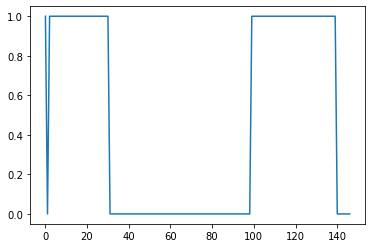

In [8]:
plt.plot(op_action_hold)
plt.show()

In [18]:
env.close()

In [ ]:
total_overlap = []
for episode in range(10):
    
    correct_hold = []
    op_action_hold = []
    op_action_prob_hold = []
    op_action_logit_hold = torch.Tensor()
    
    #Statistics to generate
    trial_mean_overlap = []
    trial_mean_std = []
    trial_delta = []

    for trial in range(30):
        
        prev_obs = None
        obs = env.reset()

        op_obs = policy.pre_process(obs, prev_obs, opponent=True)

        op_action_pred, op_action_prob, op_action_logit = policy(op_obs)


        overlap_hold = []
        score = 0

        for t in range(10000):
            env.render()

            #Preprocess the images for more model and efficient state extraction:
            a_obs = policy.pre_process(obs, prev_obs)
            op_obs = policy.pre_process(obs, prev_obs, opponent=True)

            ##############################################
            ########## Checks for Overlap ################

            #TODO: Fix this jank, but just for testing now:
            filtered_obs = policy.state_to_tensor(obs)
            overlap_hold.append(is_overlap(filtered_obs))

            op_action_real = get_opponent_action(obs, prev_obs)

            if op_action_real >= 0:
                op_action_hold.append(torch.tensor(op_action_real))
                op_action_prob_hold.append(op_action_prob)
                op_action_logit_hold = torch.cat((op_action_logit_hold,op_action_logit))
                correct_hold.append(op_action_real == op_action_pred)


            action, action_prob, _ = policy(a_obs)
            op_action_pred, op_action_prob, op_action_logit = policy(op_obs)

            prev_obs = obs
            obs, reward, done, info = env.step(policy.convert_action(action))
            score += reward

            if done:
                print('Episode %d (%d timesteps) - Reward: %.2f' % (episode, t, reward))
                break
                
        actions_stack = torch.stack(op_action_hold)
        actions_stack = one_hot_embedding(actions_stack, 2)

        op_action_logit_hold, actions_stack = op_action_logit_hold, actions_stack
        # Clear the previous gradients
        optimizer.zero_grad()

        loss = criterion(op_action_logit_hold, actions_stack)
        # Compute gradients
        loss.backward()
        # Adjust weights
        optimizer.step()

        mean_overlap = np.mean(overlap_hold)


        print("{}% correct guesses".format(np.mean(correct_hold)))
        print("{} Cross Entropy Loss".format(loss.item()))
        print("{} % overlap".format(mean_overlap))

        total_overlap.append(mean_overlap)
    
env.close()


In [30]:
obs = env.reset()

In [31]:
for i in range(100):
     prev_obs, reward, done, info = env.step(2)
obs, reward, done, info = env.step(3)
a_obs = policy.pre_process(obs, prev_obs)
op_obs = policy.pre_process(obs, prev_obs, opponent=True)

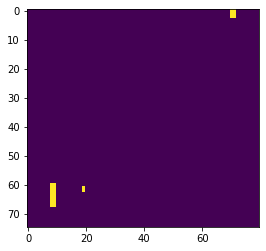

In [35]:
plt.imshow(a_obs.view(2,75,80)[1])

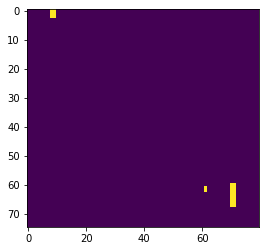

In [36]:
plt.imshow(op_obs.view(2,75,80)[1])

In [51]:
total_overlap = []
for episode in range(1):
    prev_obs = None
    obs = env.reset()

    op_obs = policy.pre_process(obs, prev_obs, opponent=True)

    op_action_pred, op_action_prob, op_action_logit = policy(op_obs)

    '''op_action_pred = -1
    op_action_prob = 0
    op_action_logit = 0'''

    correct_hold = []
    op_action_hold = []
    op_action_prob_hold = []
    op_action_logit_hold = torch.Tensor()
    
    overlap_hold = []



    for t in range(10000):
        env.render()

        #Preprocess the images for more model and efficient state extraction:
        a_obs = policy.pre_process(obs, prev_obs)
        
        ##############################################
        ########## Checks for Overlap ################
        
        #TODO: Fix this jank, but just for testing now:
        filtered_obs = policy.state_to_tensor(obs)
        overlap_hold.append(is_overlap(filtered_obs))


        action, action_prob, _ = policy(a_obs)

        prev_obs = obs
        obs, reward, done, info = env.step(policy.convert_action(action))

        if done:
            print('Episode %d (%d timesteps) - Reward: %.2f' % (episode, t, reward))
            break

    
    mean_overlap = np.mean(overlap_hold)
    
    print("{} % overlap".format(mean_overlap))
    
    total_overlap.append(mean_overlap)
    
env.close()


0.3106 % overlap


In [66]:
policy(a_obs)

(tensor([0]),
 tensor([0.8975], grad_fn=<IndexBackward>),
 tensor([[ 1.1177, -1.0518]], grad_fn=<AddmmBackward>))

In [67]:
policy.layers(a_obs)

tensor([[ 1.1177, -1.0518]], grad_fn=<AddmmBackward>)

In [68]:
a_obs.shape

torch.Size([1, 12000])